### AIM: 
#### 1. Check data/feature quality for different values of decimation & for different frequency distributions
#### 2. and select parameters which result in low TFR object file size but still show good data quality

This file contains the code pertaining to the main conclusions, see supplem_decimation_and_freqs_param_selection.ipynb for all written code related to decimate & freqs parameter selection.

### Conclusion after results:
decimate=8 results in significant file size reduction, while still relatively keeping the data quality. In some channels and/or frequencies there is a ~1% difference in the std of the power compared to decimate=1. Considering, data will be averaged over multiple channels and frequencies, a maximum of 1% difference in some data points seems negligible. decimate=8 will therefore be selected for further TF analysis

Furthermore, the frequency distributions seem to have no effect on the std of the power per channel per frequency. The number of frequencies does, however, have a great effect on file size. 30 logspaced frequency steps does not seem to equally represent each frequency band, as compared to frequency distribution with 5 steps per frequency band. The frequency distribution with 5 steps per frequency band will therefore be selected for further TF analysis.

### Code:

In [26]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet, tfr_multitaper

%matplotlib inline

In [27]:
# prevent extensive logging
mne.set_log_level('WARNING')

In [28]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }


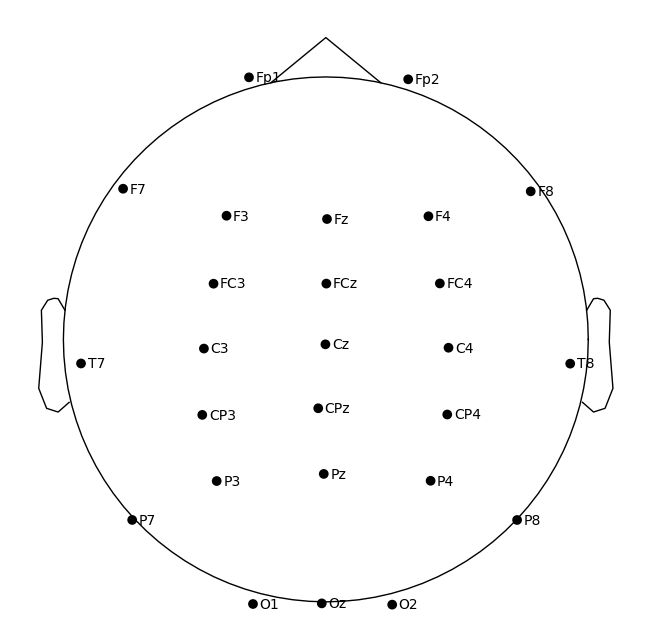

In [29]:
## Set montage and plot electrodes (Copied from Anne van Duijvenbode)

montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')
mne.viz.plot_montage(montage = montage, scale_factor=10, show_names=True, show=True, sphere='eeglab')

montage.save('montage_eeg.fif', overwrite = True)

In [30]:
# Create info object for MNE
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG, 5 EOG, 1 ECG, 1 EMG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>


In [31]:
# load data of a singular session of a singular participant and create epochs
eeg_data_path = 'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\sub-88078657\ses-1\eeg\sub-88078657_ses-1_task-restEC_eeg.csv'
eeg_data = pd.read_csv(eeg_data_path, sep=',')
eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
raw.notch_filter(50)
raw.filter(0.5, 100)
        
epochs = mne.make_fixed_length_epochs(raw, duration = 10, overlap = 0) # overlap 0?
print(epochs)

<Epochs |  12 events (good & bad), 0 – 9.998 s, baseline off, ~40 kB, data not loaded,
 '1': 12>


### Checking effect of less frequencies & decimate parameter on file size and on STD of power per freq per channel

In [32]:
# define frequencies of interest
freq_1 = np.logspace(*np.log10([0.5, 90]), num=90) # 90 logspaced steps
freq_2 = np.logspace(*np.log10([0.5, 90]), num=30) # 30 logspaced steps
freq_3 = np.array([                                # 5 steps per frequency band
    0.5, 1.125, 1.75, 2.375, 3, # delta 
    4, 4.75, 5.5, 6.25, 7, # theta
    8, 9, 10, 11, 12, # alpha
    13, 17.25, 21.5, 25.75, 30, # beta
    42, 54, 66, 78, 90 # gamma
    ])


In [33]:
# define frequencies of interest
freqs = [freq_1, freq_2, freq_3]

# Create TFR objects with different values of 'decimate' and different frequency resolution
decim_params = [1, 2, 4, 8]
TFR_objects = {}
i = 1

for freq in freqs:
    TFR_decim = {}
    for decim_param in decim_params:
        n_cycles = freq / 2.0 # different number of cycles per frequency
        TFR_object = tfr_multitaper(
            epochs,
            freqs=freq,
            n_cycles=n_cycles,
            time_bandwidth=4, # just random for now
            use_fft=True,
            return_itc=False,
            average=False,
            decim=decim_param, # decim reduces sampling rate of the tf decomposition by the defined factor
            n_jobs=-1)
        TFR_object.apply_baseline((0, 0.5), mode='mean') # baseline correction
        TFR_decim[f'{decim_param = }'] = TFR_object
    TFR_objects[f'freq_{i}'] = TFR_decim
    i += 1
print(TFR_objects)

{'freq_1': {'decim_param = 1': <EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~1.05 GB>, 'decim_param = 2': <EpochsTFR | time : [0.000000, 9.996000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~535.6 MB>, 'decim_param = 4': <EpochsTFR | time : [0.000000, 9.992000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~267.8 MB>, 'decim_param = 8': <EpochsTFR | time : [0.000000, 9.984000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~133.9 MB>}, 'freq_2': {'decim_param = 1': <EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~357.1 MB>, 'decim_param = 2': <EpochsTFR | time : [0.000000, 9.996000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~178.6 MB>, 'decim_param = 4': <EpochsTFR | time : [0.000000, 9.992000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~89.3 MB>, 'decim_param = 8': <EpochsTFR | time : [0.000000, 9.984000], 

In [34]:
# extract estimated file size
file_sizes = []
for freq in TFR_objects:
    for decim_param in TFR_objects[freq]:
        file_size = str(TFR_objects[freq][decim_param]).split(',')[6].replace(' ', '').replace('>', '')
        file_sizes.append(file_size)
print(file_sizes)

['~1.05GB', '~535.6MB', '~267.8MB', '~133.9MB', '~357.1MB', '~178.6MB', '~89.3MB', '~44.7MB', '~297.6MB', '~148.8MB', '~74.4MB', '~37.2MB']


In [35]:
# create text table for easy comparison of object shape and corresponding file size
print('shape = [n_epochs, n_channels, n_freqs, n_times]')
i = 0
for freq in TFR_objects:    
    for TFR_object in TFR_objects[freq].values():
        print(f'shape = {TFR_object.data.shape}, {file_sizes[i] = }')
        i += 1

shape = [n_epochs, n_channels, n_freqs, n_times]
shape = (12, 26, 90, 5000), file_sizes[i] = '~1.05GB'
shape = (12, 26, 90, 2500), file_sizes[i] = '~535.6MB'
shape = (12, 26, 90, 1250), file_sizes[i] = '~267.8MB'
shape = (12, 26, 90, 625), file_sizes[i] = '~133.9MB'
shape = (12, 26, 30, 5000), file_sizes[i] = '~357.1MB'
shape = (12, 26, 30, 2500), file_sizes[i] = '~178.6MB'
shape = (12, 26, 30, 1250), file_sizes[i] = '~89.3MB'
shape = (12, 26, 30, 625), file_sizes[i] = '~44.7MB'
shape = (12, 26, 25, 5000), file_sizes[i] = '~297.6MB'
shape = (12, 26, 25, 2500), file_sizes[i] = '~148.8MB'
shape = (12, 26, 25, 1250), file_sizes[i] = '~74.4MB'
shape = (12, 26, 25, 625), file_sizes[i] = '~37.2MB'


In [36]:
# create list of TFR objects for easy indexing in plotting
TFR_objects_list = []
for freq in TFR_objects:    
    for TFR_object in TFR_objects[freq].values():
        TFR_objects_list.append(TFR_object)

print(TFR_objects_list)
print(len(TFR_objects_list))

[<EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~1.05 GB>, <EpochsTFR | time : [0.000000, 9.996000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~535.6 MB>, <EpochsTFR | time : [0.000000, 9.992000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~267.8 MB>, <EpochsTFR | time : [0.000000, 9.984000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~133.9 MB>, <EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~357.1 MB>, <EpochsTFR | time : [0.000000, 9.996000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~178.6 MB>, <EpochsTFR | time : [0.000000, 9.992000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~89.3 MB>, <EpochsTFR | time : [0.000000, 9.984000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~44.7 MB>, <EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 90.000000], epochs : 12, channels : 26, ~297.6

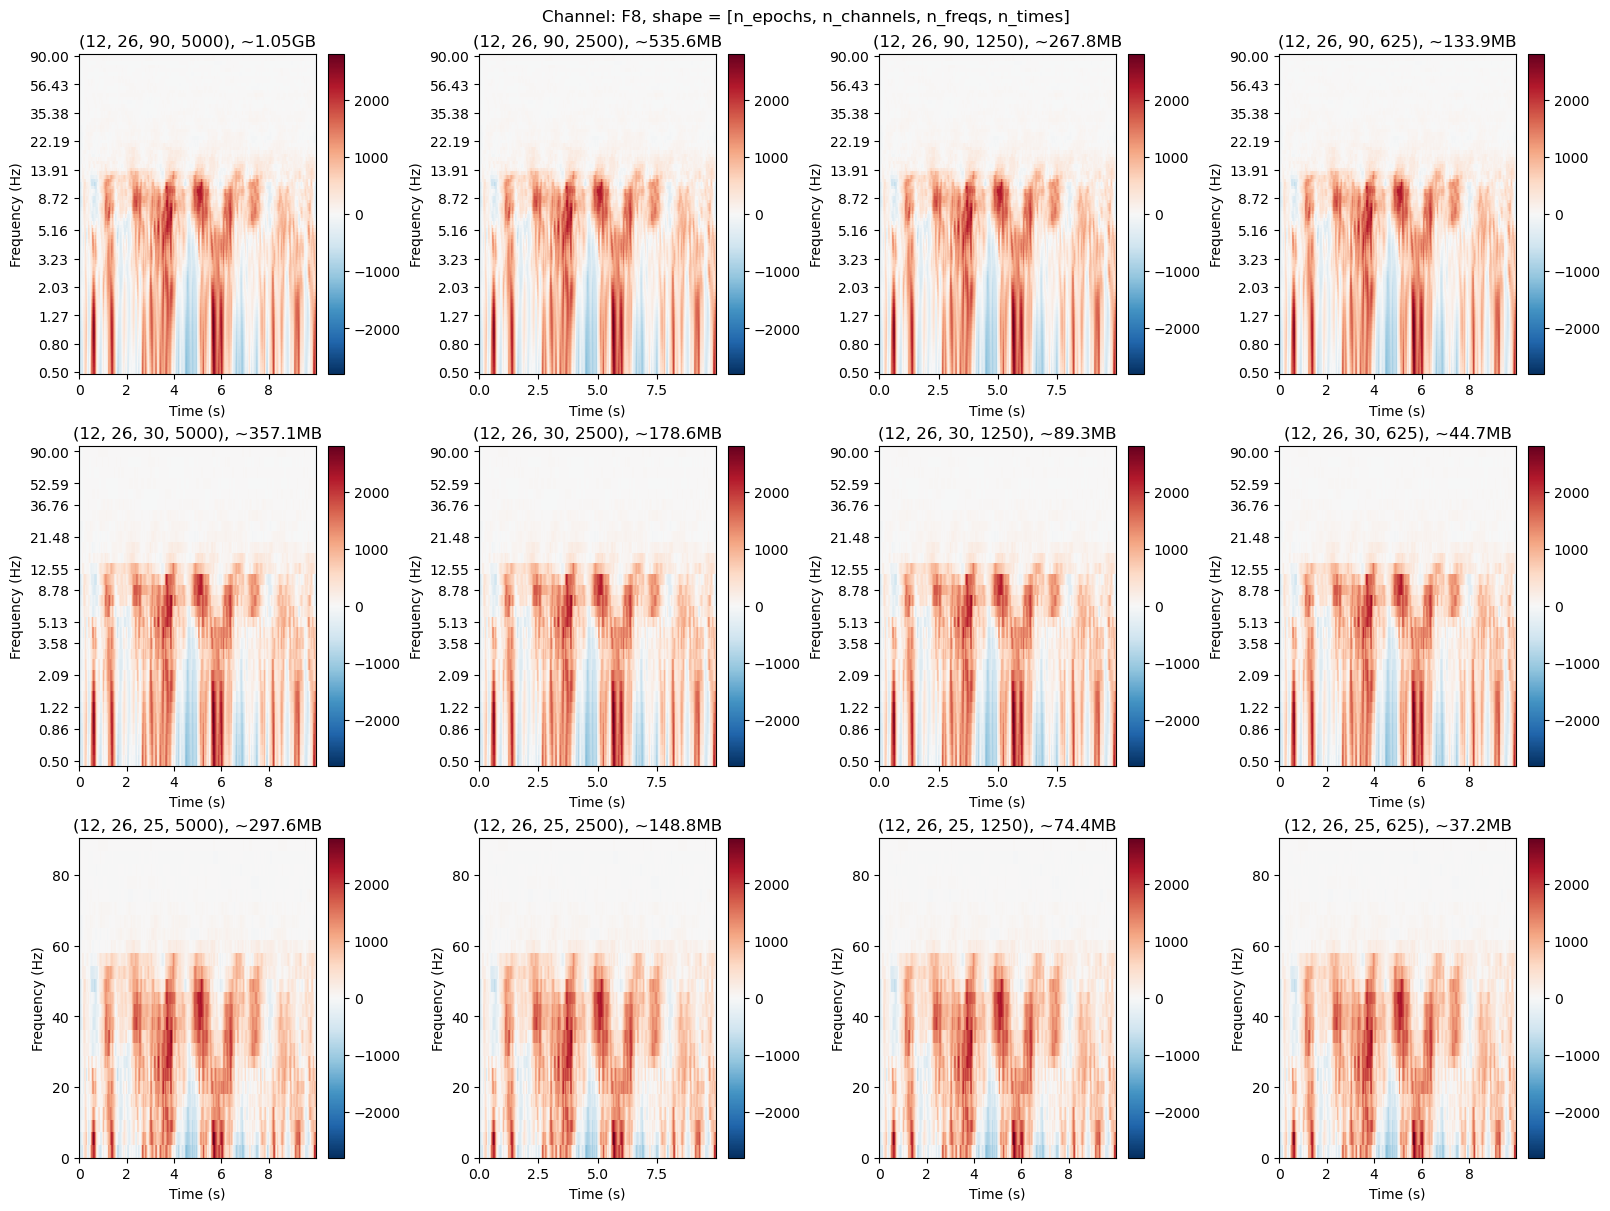

In [37]:
# plot all TFR_objects to visualize effect of 'decimate' parameter
fig, axes = plt.subplots(3, 4, figsize=(16, 12), layout='constrained')

for ax, TFR_object, file_size in zip(axes.ravel(), TFR_objects_list, file_sizes):
        TFR_object.average().plot([6], axes=ax, show=False) # Have to average over epochs and select only 1 channel, in order to plot
        ax.set_title(f'{TFR_object.data.shape}, {file_size}')
fig.suptitle(f'Channel: {ch_names[6]}, shape = [n_epochs, n_channels, n_freqs, n_times]')
plt.show()
    

In [38]:
# calculate stdev of power per freq per channel (averaged over epochs)
stdevs_dict = {}

for freq in TFR_objects:
    decim_params = {}
    for decim_param, TFR_object in TFR_objects[freq].items():
        #print(TFR_object.average().data.shape)
        stdev = np.std(TFR_object.average().data, axis=2)
        #print(stdev.shape)
        decim_params[decim_param] = stdev
    stdevs_dict[freq] = decim_params

In [39]:
# check if shape of arrays are correct
for freq in stdevs_dict:
    for decim_param in stdevs_dict[freq]:
        print(freq, decim_param, stdevs_dict[freq][decim_param].shape, stdevs_dict[freq][decim_param][0,0]) 

# Weirdly (?), the stdev does not seem to change depending on the # of frequencies used
# It does change depending on decimation

freq_1 decim_param = 1 (26, 90) 1080.3329541354206
freq_1 decim_param = 2 (26, 90) 1080.3866236711704
freq_1 decim_param = 4 (26, 90) 1080.497692182914
freq_1 decim_param = 8 (26, 90) 1080.473643059382
freq_2 decim_param = 1 (26, 30) 1080.3329541354206
freq_2 decim_param = 2 (26, 30) 1080.3866236711704
freq_2 decim_param = 4 (26, 30) 1080.497692182914
freq_2 decim_param = 8 (26, 30) 1080.473643059382
freq_3 decim_param = 1 (26, 25) 1080.3329541354206
freq_3 decim_param = 2 (26, 25) 1080.3866236711704
freq_3 decim_param = 4 (26, 25) 1080.497692182914
freq_3 decim_param = 8 (26, 25) 1080.473643059382


In [40]:
# create list of stdevs and list of decim_params for easy indexing for plotting
stdevs_list = []
decim_params_list = []
for freq in stdevs_dict:
    for decim_param, stdev in stdevs_dict[freq].items():
        print(stdev.shape)
        print(decim_param)
        stdevs_list.append(stdev)
        decim_params_list.append(decim_param)

print(len(stdevs_list))
print(len(decim_params_list))

(26, 90)
decim_param = 1
(26, 90)
decim_param = 2
(26, 90)
decim_param = 4
(26, 90)
decim_param = 8
(26, 30)
decim_param = 1
(26, 30)
decim_param = 2
(26, 30)
decim_param = 4
(26, 30)
decim_param = 8
(26, 25)
decim_param = 1
(26, 25)
decim_param = 2
(26, 25)
decim_param = 4
(26, 25)
decim_param = 8
12
12


Text(0.5, 0.98, '------------------------------------------------------------------------------------------------------------------------- 5 FREQ STEPS PER FREQUENCY BAND -------------------------------------------------------------------------------------------------------------------------')

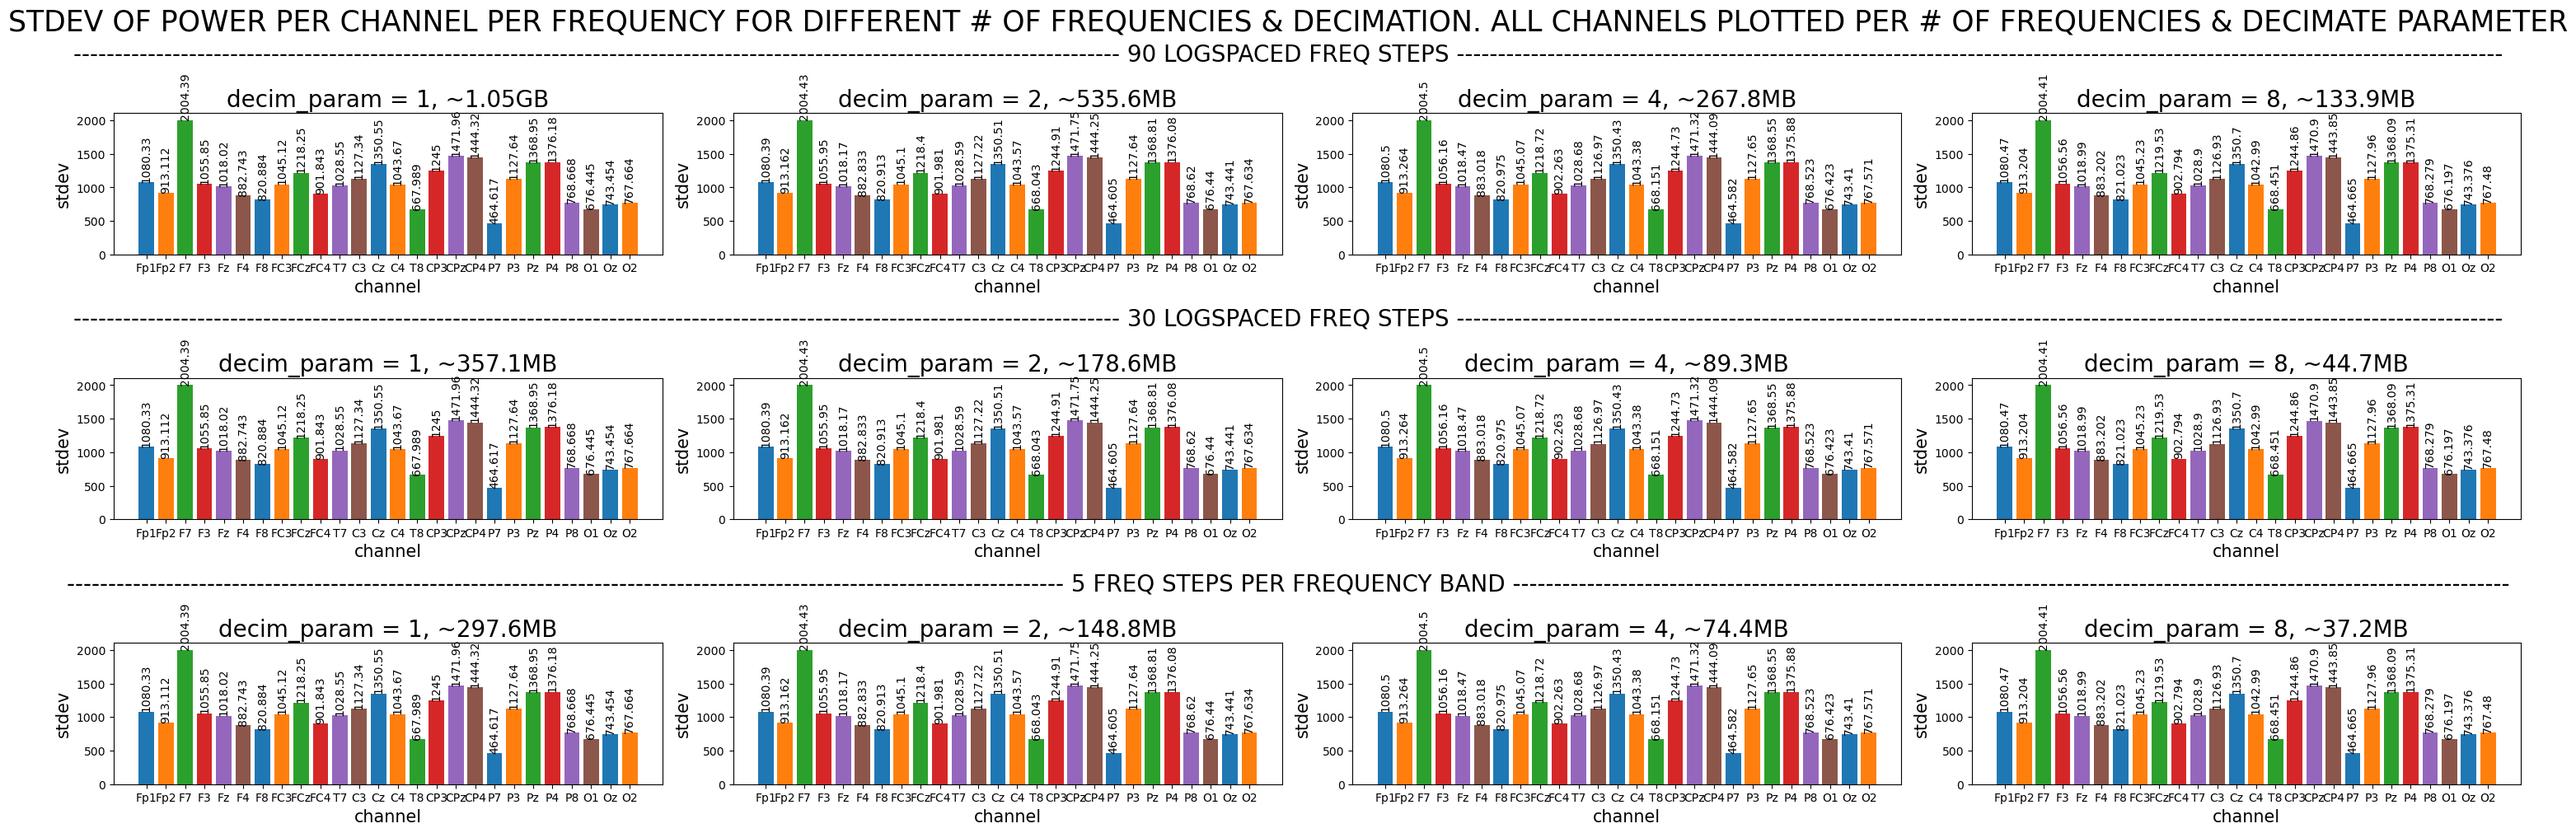

In [41]:
# create plot to compare effect of # of frequencies & decimate parameter on stdev of power per channel per frequency
# code reference: https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
fig = plt.figure(constrained_layout=True, figsize=(30, 10))
fig.suptitle('STDEV OF POWER PER CHANNEL PER FREQUENCY FOR DIFFERENT # OF FREQUENCIES & DECIMATION. ALL CHANNELS PLOTTED PER # OF FREQUENCIES & DECIMATE PARAMETER', fontsize=25)
i = 0
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for subfig in subfigs:

    # create 1x3 subplots per subfig
    axes = subfig.subplots(nrows=1, ncols=4)
    for ax in axes:
        stdev = stdevs_list[i]
        #print(stdev[:6, 0])
        ax.bar(ch_names[:26], stdev[:, 0], color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']) # shape = [n_channels, n_freqs]
        ax.bar_label(ax.containers[0], label_type='edge', rotation=90)
        ax.set_title(f'{decim_params_list[i]}, {file_sizes[i]}', fontsize=20)
        ax.set_ylabel('stdev', fontsize=15)
        ax.set_xlabel('channel', fontsize=15)
        i += 1

subfigs[0].suptitle('------------------------------------------------------------------------------------------------------------------------------- 90 LOGSPACED FREQ STEPS -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[1].suptitle('------------------------------------------------------------------------------------------------------------------------------- 30 LOGSPACED FREQ STEPS -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[2].suptitle('------------------------------------------------------------------------------------------------------------------------- 5 FREQ STEPS PER FREQUENCY BAND -------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)

Text(0.5, 0.98, '------------------------------------------------------------------------------------------------------------------------- 5 FREQ STEPS PER FREQUENCY BAND -------------------------------------------------------------------------------------------------------------------------')

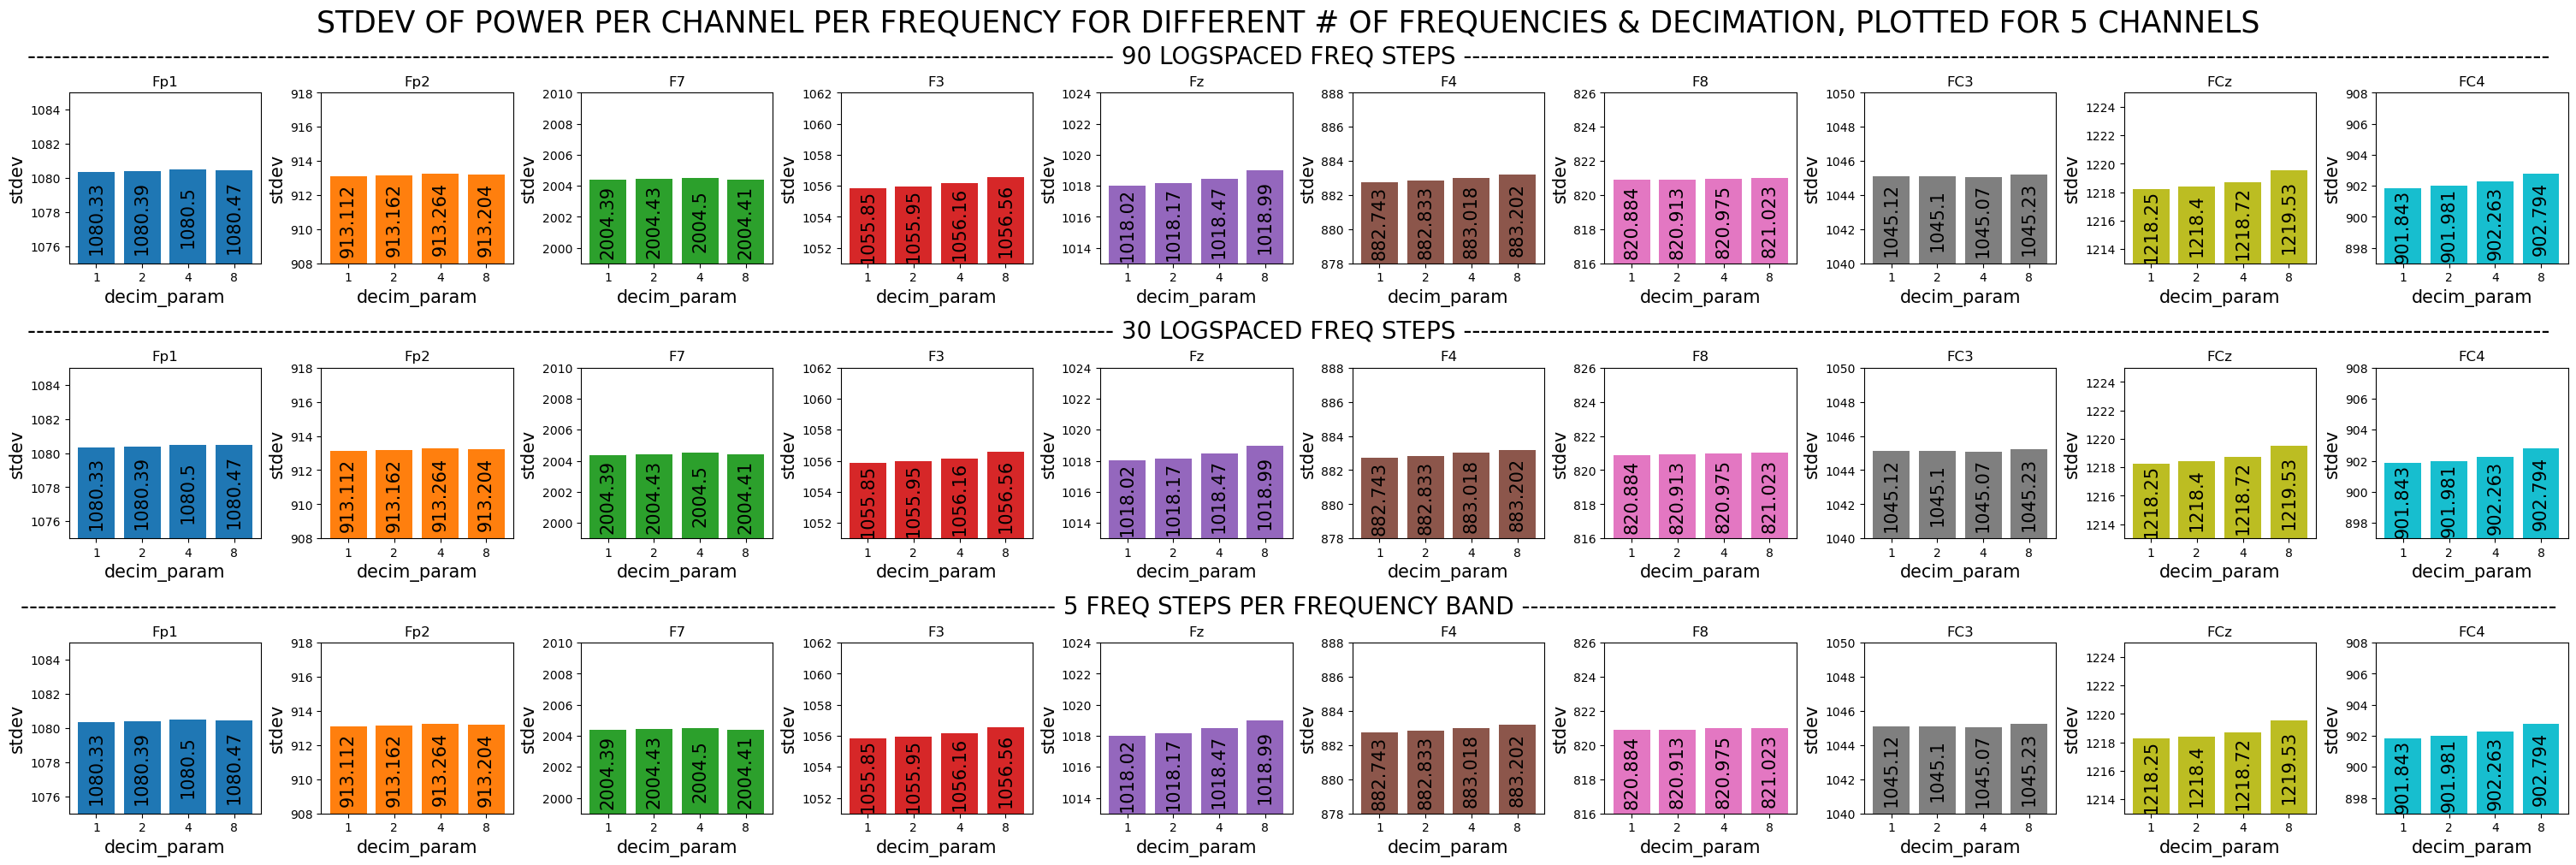

In [42]:
# create plot to compare effect of # of frequencies & decimate parameter on stdev of power per channel per frequency
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
fig = plt.figure(constrained_layout=True, figsize=(30, 10))
fig.suptitle('STDEV OF POWER PER CHANNEL PER FREQUENCY FOR DIFFERENT # OF FREQUENCIES & DECIMATION, PLOTTED FOR 5 CHANNELS', fontsize=25)
i = 0
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for subfig, freq in zip(subfigs, TFR_objects):

    # create 1x3 subplots per subfig
    axes = subfig.subplots(nrows=1, ncols=10)
    for j, ax in enumerate(axes):
        stdevs = list(stdevs_dict[freq].values())
        stdevs = [stdev[j, 0] for stdev in stdevs]
        decim_params = [decim_param.split(' ')[2] for decim_param in decim_params_list]
        #print(len(stdevs))
        #print(stdevs)
        ax.bar(decim_params[:4], stdevs, color=color_list[j])
        ax.set_ylim(round(min(stdevs)) - 5, round(max(stdevs)) + 5)
        ax.bar_label(ax.containers[0], label_type='center', rotation = 90, fontsize=15)
        ax.set_title(f'{ch_names[j]}')
        ax.set_ylabel('stdev', fontsize=15)
        ax.set_xlabel('decim_param', fontsize=15)
        i += 1

subfigs[0].suptitle('------------------------------------------------------------------------------------------------------------------------------- 90 LOGSPACED FREQ STEPS -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[1].suptitle('------------------------------------------------------------------------------------------------------------------------------- 30 LOGSPACED FREQ STEPS -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[2].suptitle('------------------------------------------------------------------------------------------------------------------------- 5 FREQ STEPS PER FREQUENCY BAND -------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)

Text(0.5, 0.98, '------------------------------------------------------------------------------------------------------------------------- 5 FREQ STEPS PER FREQUENCY BAND -------------------------------------------------------------------------------------------------------------------------')

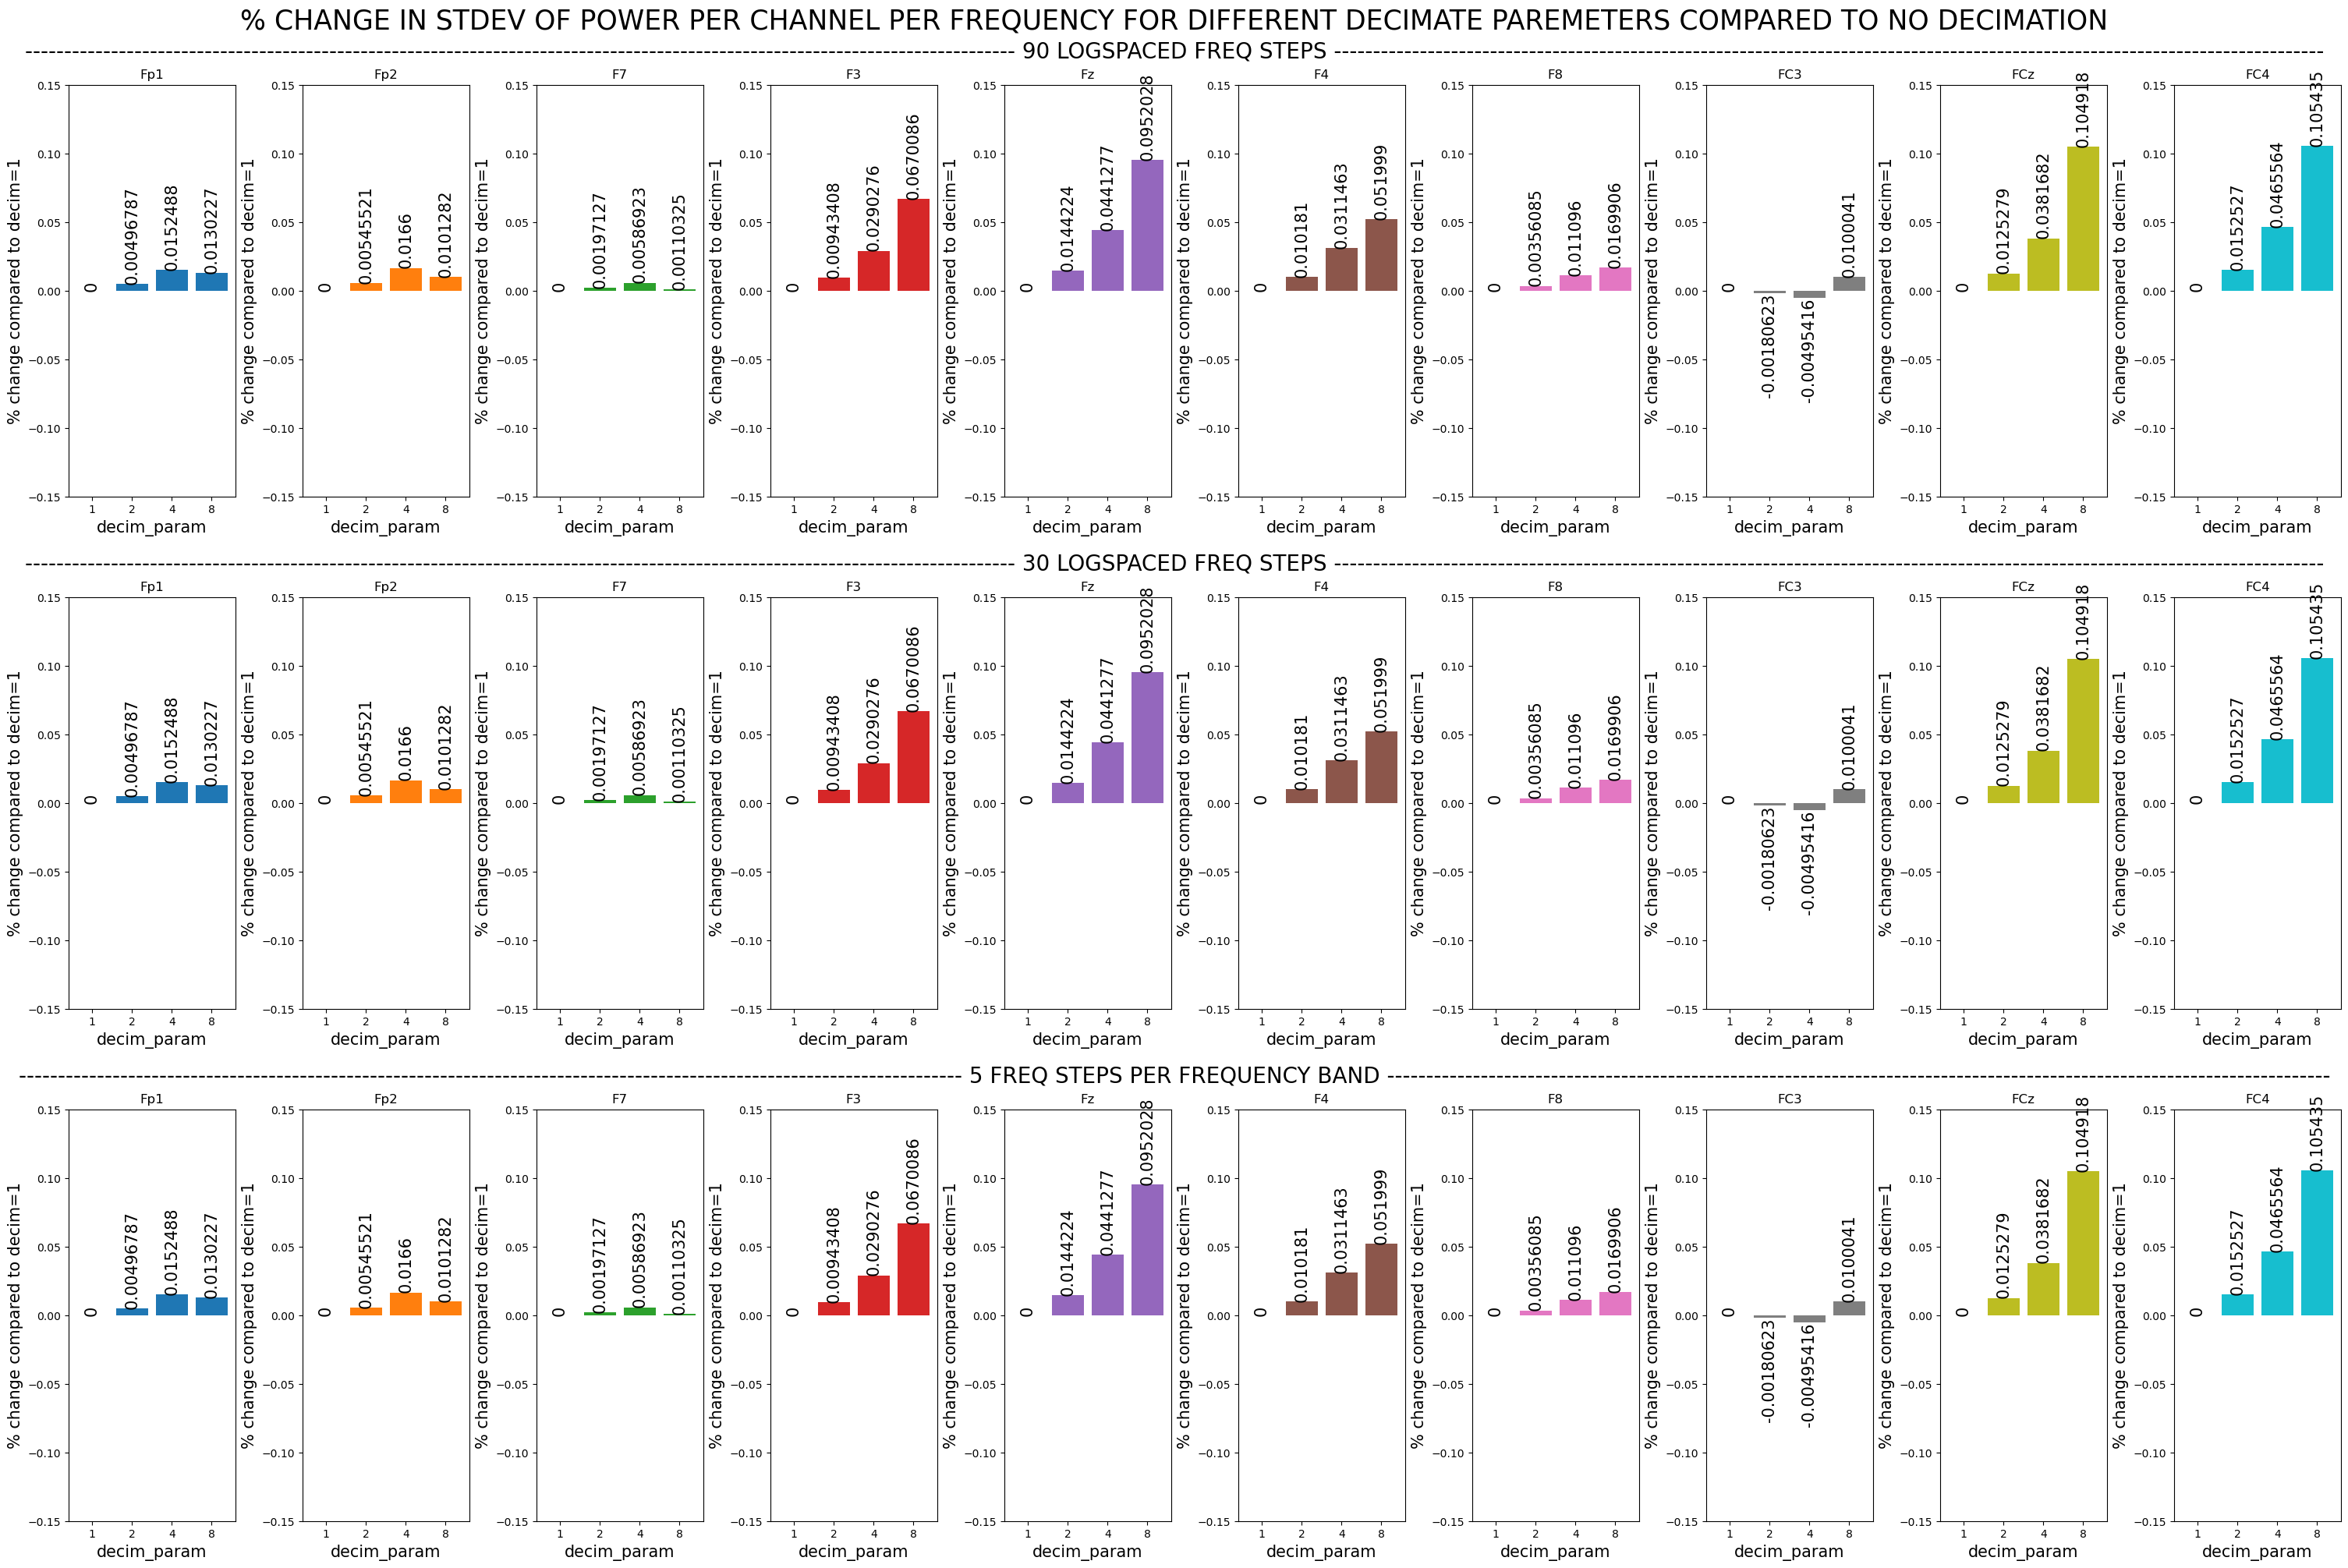

In [43]:
# create plot to compare % effect of # of frequencies & decimate parameter on stdev of power per channel per frequency
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
fig = plt.figure(constrained_layout=True, figsize=(30, 20))
fig.suptitle('% CHANGE IN STDEV OF POWER PER CHANNEL PER FREQUENCY FOR DIFFERENT DECIMATE PAREMETERS COMPARED TO NO DECIMATION', fontsize=25)
i = 0
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for subfig, freq in zip(subfigs, TFR_objects):

    # create 1x3 subplots per subfig
    axes = subfig.subplots(nrows=1, ncols=10)
    for j, ax in enumerate(axes):
        stdevs = list(stdevs_dict[freq].values())
        stdevs = [stdev[j, 0] for stdev in stdevs]
        decim_params = [decim_param.split(' ')[2] for decim_param in decim_params_list]
        stdevs_perc = [(((stdev - stdevs[0]) / stdevs[0]) * 100) for stdev in stdevs] # calculate % change in stdev compared to no decimation
        #print(len(stdevs))
        #print(stdevs)
        ax.bar(decim_params[:4], stdevs_perc[:4], color=color_list[j])
        ax.set_ylim(-0.15, 0.15)
        ax.bar_label(ax.containers[0], label_type='edge', rotation = 90, fontsize=15)
        ax.set_title(f'{ch_names[j]}')
        ax.set_ylabel('% change compared to decim=1', fontsize=15)
        ax.set_xlabel('decim_param', fontsize=15)
        i += 1

subfigs[0].suptitle('------------------------------------------------------------------------------------------------------------------------------- 90 LOGSPACED FREQ STEPS -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[1].suptitle('------------------------------------------------------------------------------------------------------------------------------- 30 LOGSPACED FREQ STEPS -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[2].suptitle('------------------------------------------------------------------------------------------------------------------------- 5 FREQ STEPS PER FREQUENCY BAND -------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)

Text(0.5, 0.98, '------------------------------------------------------------------------------------------------------------------------------- FREQ 36.76227863033306 Hz -------------------------------------------------------------------------------------------------------------------------------')

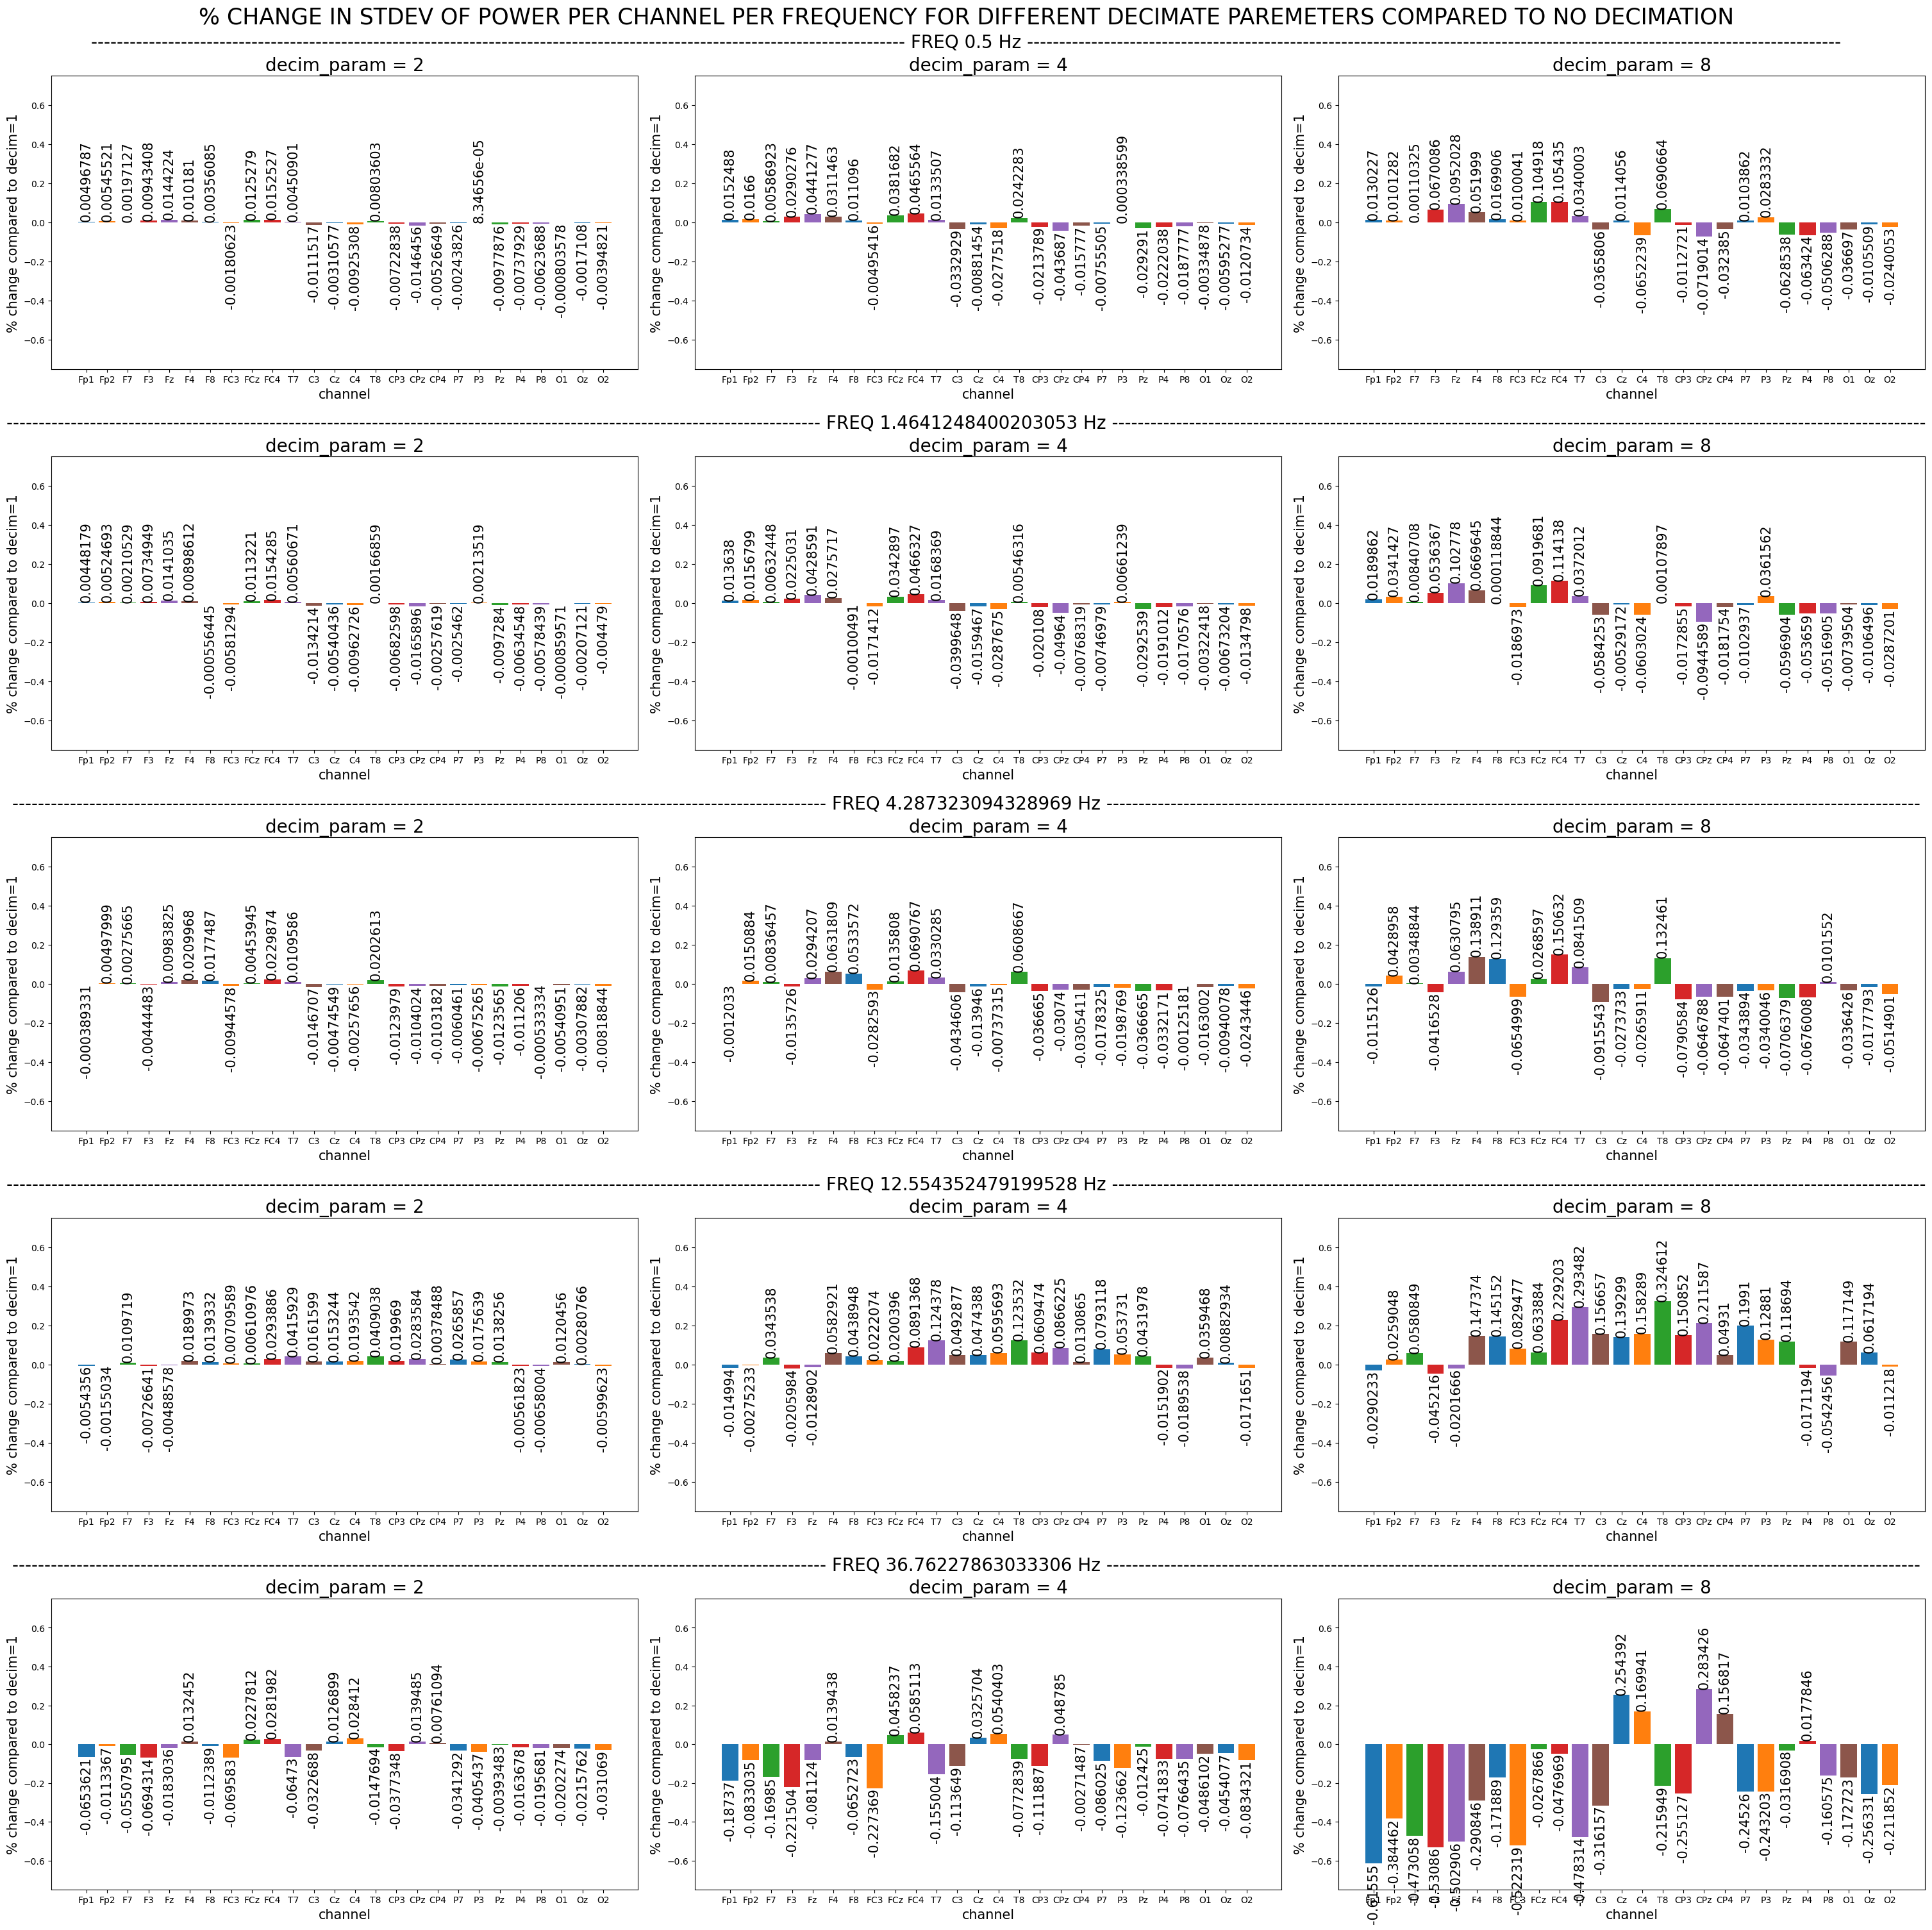

In [45]:
# create plot to compare effect of # of frequencies & decimate parameter on stdev of power per channel per frequency
# code reference: https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
fig = plt.figure(constrained_layout=True, figsize=(30, 30))
fig.suptitle('% CHANGE IN STDEV OF POWER PER CHANNEL PER FREQUENCY FOR DIFFERENT DECIMATE PAREMETERS COMPARED TO NO DECIMATION', fontsize=25)
stdevs = stdevs_list[4:8]
decim_params_list = ['decim_param = 2', 'decim_param = 4', 'decim_param = 8']
i = 0
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=5, ncols=1)
for subfig in subfigs:
    stdev_freq = [stdev[:, i] for stdev in stdevs] # select all channels for a specific frequency

    # create 1x3 subplots per subfig
    axes = subfig.subplots(nrows=1, ncols=3)
    for j, ax in enumerate(axes, 1):
        stdevs_perc = [(((stdev - stdev_freq[0]) / stdev_freq[0]) * 100) for stdev in stdev_freq] # calculate % change in stdev compared to no decimation (decimate=1)
        #print(stdevs_perc[j])

        ax.bar(ch_names[:26], stdevs_perc[j], color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'])
        ax.bar_label(ax.containers[0], label_type='edge', rotation=90, fontsize=15)
        ax.set_ylim(-0.75, 0.75)
        ax.set_title(f'{decim_params_list[j-1]}', fontsize=20)
        ax.set_ylabel('% change compared to decim=1', fontsize=15)
        ax.set_xlabel('channel', fontsize=15)
        
    i += 6
subfigs[0].suptitle(f'------------------------------------------------------------------------------------------------------------------------------- FREQ {freq_2[0]} Hz -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[1].suptitle(f'------------------------------------------------------------------------------------------------------------------------------- FREQ {freq_2[6]} Hz -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[2].suptitle(f'------------------------------------------------------------------------------------------------------------------------------- FREQ {freq_2[12]} Hz -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[3].suptitle(f'------------------------------------------------------------------------------------------------------------------------------- FREQ {freq_2[18]} Hz -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[4].suptitle(f'------------------------------------------------------------------------------------------------------------------------------- FREQ {freq_2[24]} Hz -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)


Text(0.5, 0.98, '------------------------------------------------------------------------------------------------------------------------------- Oz -------------------------------------------------------------------------------------------------------------------------------')

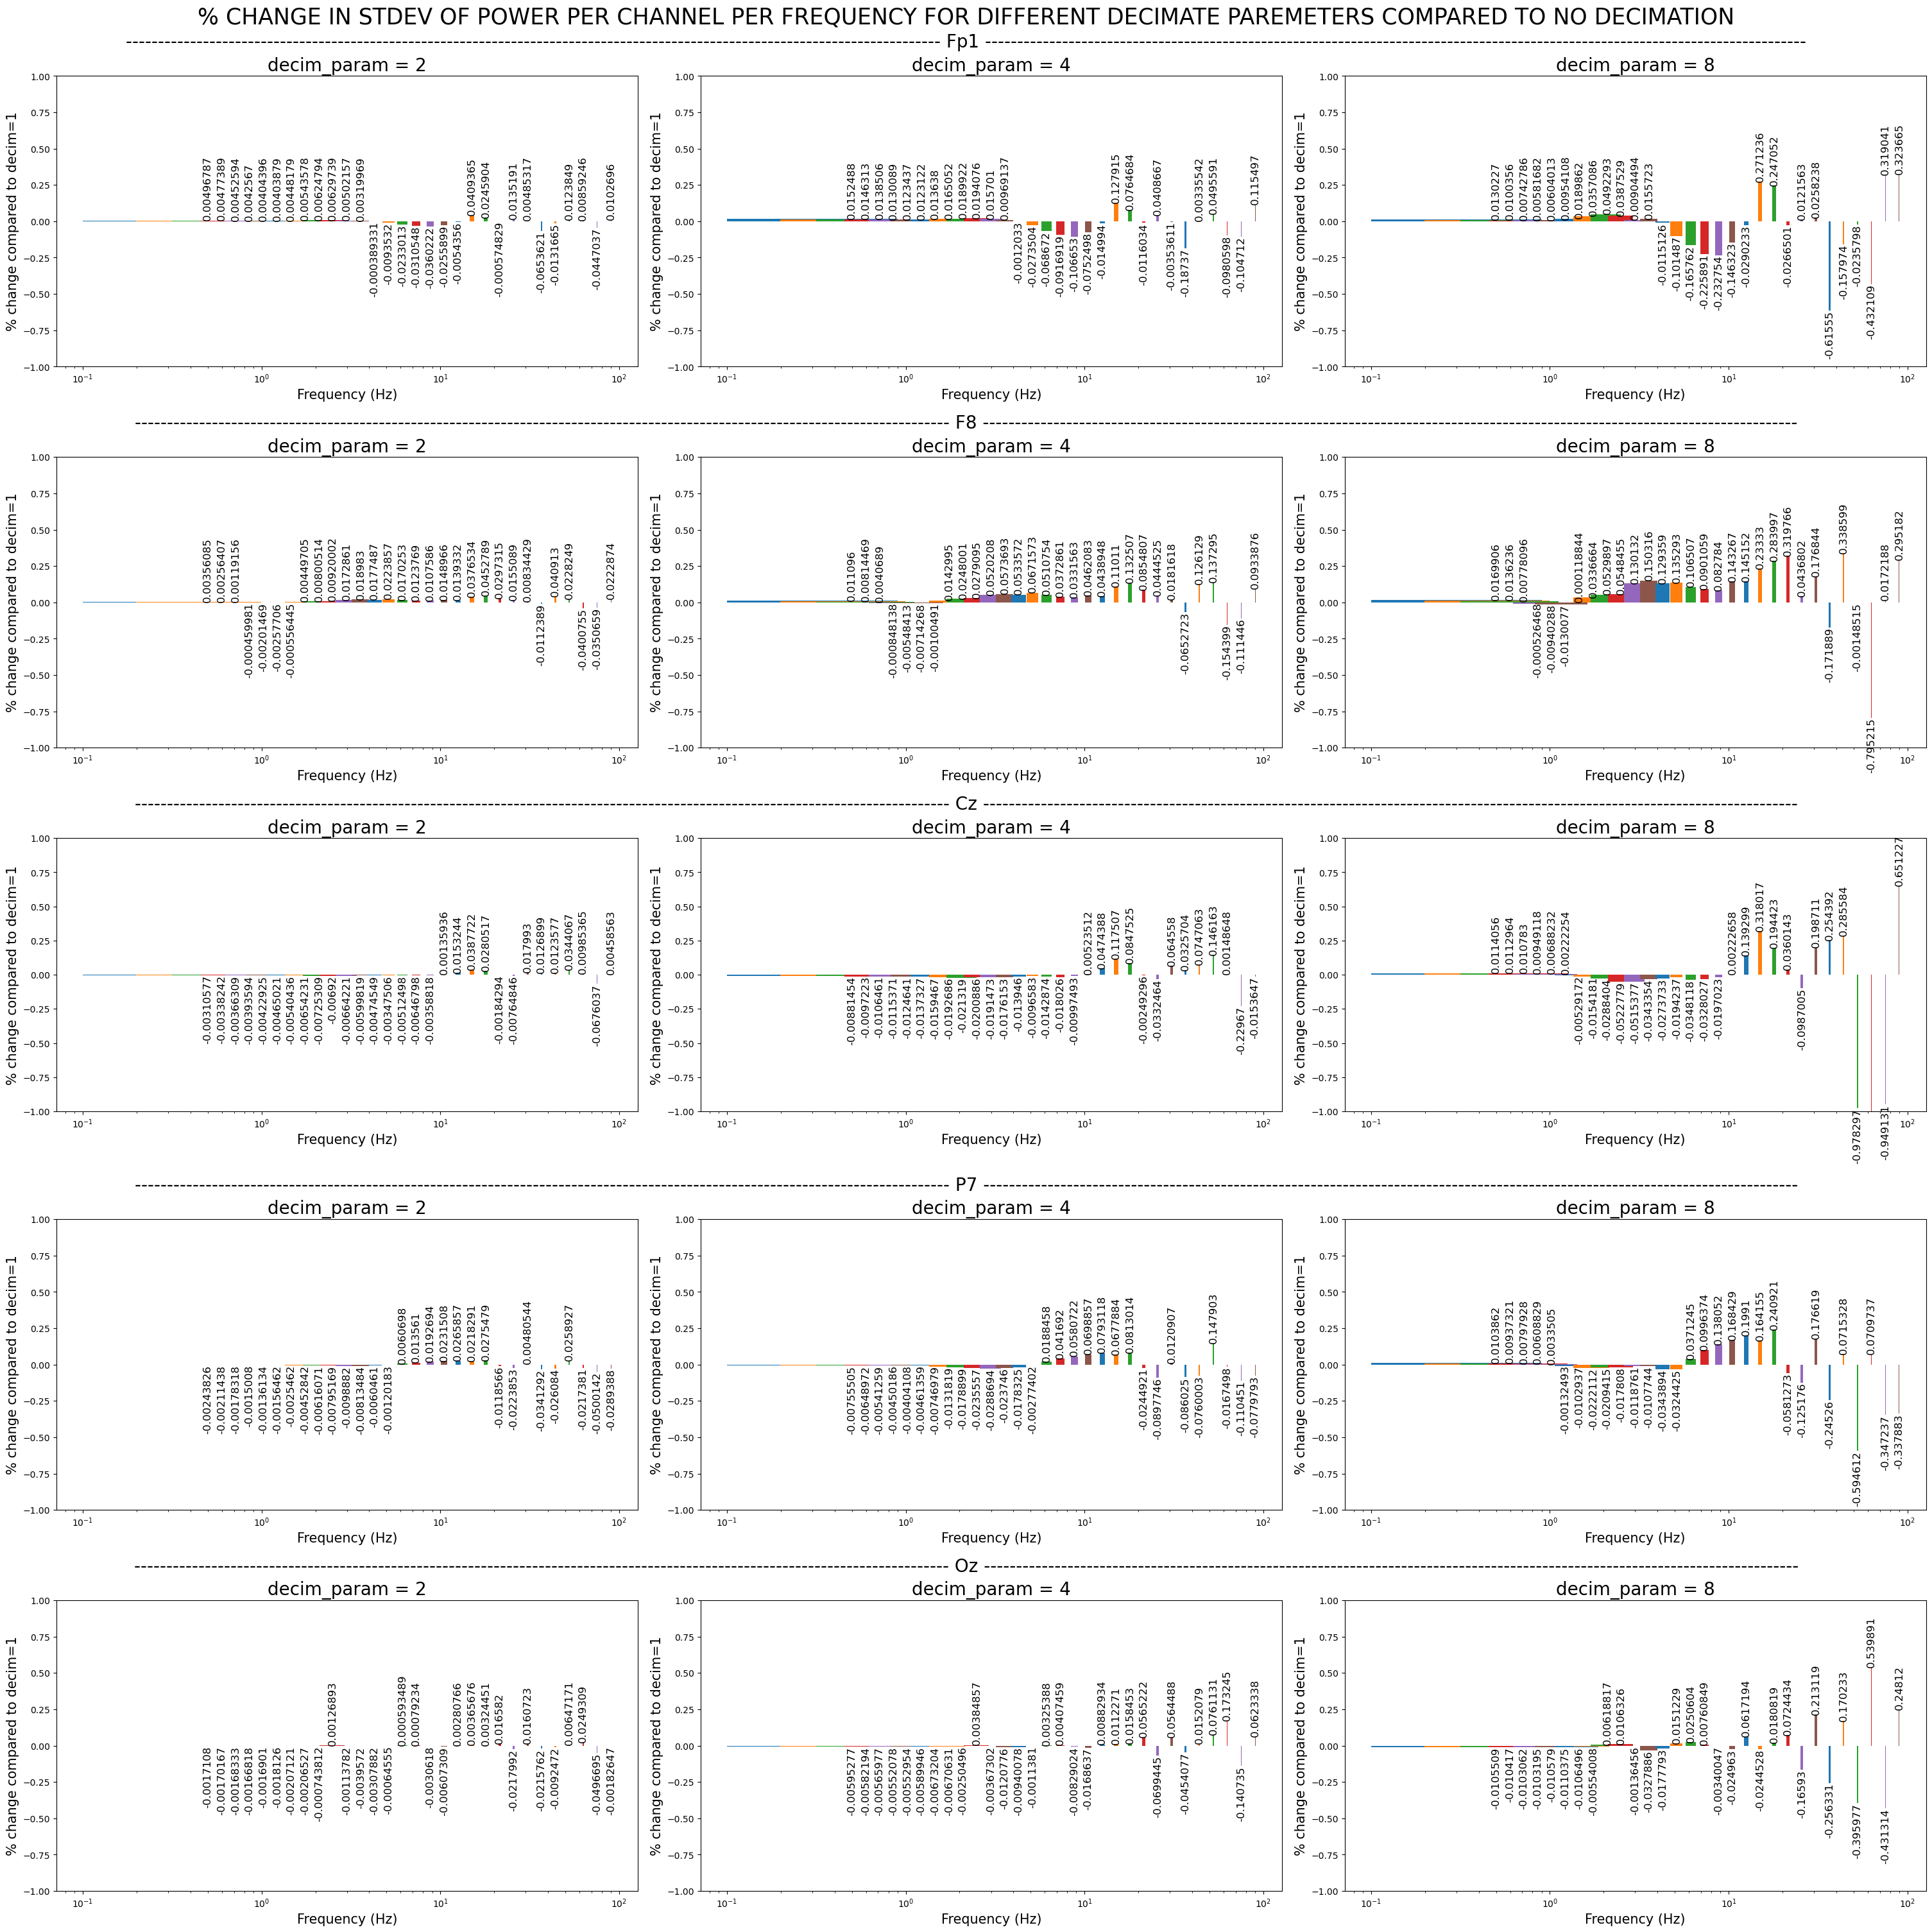

In [46]:
# create plot to compare effect of # of frequencies & decimate parameter on stdev of power per channel per frequency
# code reference: https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
fig = plt.figure(constrained_layout=True, figsize=(30, 30))
fig.suptitle('% CHANGE IN STDEV OF POWER PER CHANNEL PER FREQUENCY FOR DIFFERENT DECIMATE PAREMETERS COMPARED TO NO DECIMATION', fontsize=25)
stdevs = stdevs_list[4:8]
decim_params_list = ['decim_param = 2', 'decim_param = 4', 'decim_param = 8']
i = 0
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=5, ncols=1)
for subfig in subfigs:
    stdev_freq = [stdev[i, :] for stdev in stdevs] # select all frequencies for a specific channel
    #print(stdev_freq[0].shape)

    # create 1x3 subplots per subfig
    axes = subfig.subplots(nrows=1, ncols=3)
    for j, ax in enumerate(axes, 1):
        stdevs_perc = [(((stdev - stdev_freq[0]) / stdev_freq[0]) * 100) for stdev in stdev_freq] # calculate % change in stdev compared to no decimation
        #print(stdevs_perc[j].shape)

        ax.bar(freq_2, stdevs_perc[j], color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'])
        ax.bar_label(ax.containers[0], label_type='edge', rotation=90, fontsize=12)
        ax.set_ylim(-1, 1)
        ax.set_xscale('log', base=10)
        ax.set_title(f'{decim_params_list[j-1]}', fontsize=20)
        ax.set_ylabel('% change compared to decim=1', fontsize=15)
        ax.set_xlabel('Frequency (Hz)', fontsize=15)
        
    i += 6
subfigs[0].suptitle(f'------------------------------------------------------------------------------------------------------------------------------- {ch_names[0]} --------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[1].suptitle(f'------------------------------------------------------------------------------------------------------------------------------- {ch_names[6]} -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[2].suptitle(f'------------------------------------------------------------------------------------------------------------------------------- {ch_names[12]} -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[3].suptitle(f'------------------------------------------------------------------------------------------------------------------------------- {ch_names[18]} -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
subfigs[4].suptitle(f'------------------------------------------------------------------------------------------------------------------------------- {ch_names[24]} -------------------------------------------------------------------------------------------------------------------------------', 
                    fontsize=20)
